In [15]:
import kagglehub
import os
from PIL import Image
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torchmetrics.segmentation import DiceScore, MeanIoU
import segmentation_models_pytorch as smp
from tqdm import tqdm

device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Device: {device}")

Device: mps


# Download latest version from kaggle

In this project I use dataset from https://www.kaggle.com/datasets/abdallahwagih/retina-blood-vessel.

This dataset is already divided to train and test data. Each consist images of retina (with visible blood vessels) and mask which consist only blood vessels as target to segmentation.

In [2]:
path = kagglehub.dataset_download("abdallahwagih/retina-blood-vessel")
path = os.path.join(path, "Data")
print("Path to dataset files:", path)

Path to dataset files: /Users/dami/.cache/kagglehub/datasets/abdallahwagih/retina-blood-vessel/versions/1/Data


In [3]:
print(f"Number of samples in train set: {len(os.listdir(os.path.join(path, 'Train', 'image')))}")
print(f"Number of samples in test set : {len(os.listdir(os.path.join(path, 'Test', 'image')))}")

Number of samples in train set: 80
Number of samples in test set : 20


In [4]:
image: Image = Image.open(os.path.join(path, "Train", "image", "1.png"))
mask: Image = Image.open(os.path.join(path, "Train", "mask", "1.png"))

print(
    f"Images in dataset have size: {image.size} and are in {'GrayScale' if image.mode == 'L' else image.mode} mode, so have {len(image.getbands())} channels.")
print(
    f"Masks (target) in dataset have size: {mask.size} and are in {'GrayScale' if mask.mode == 'L' else mask.mode} mode, so have {len(mask.getbands())} channels.")

Images in dataset have size: (512, 512) and are in RGB mode, so have 3 channels.
Masks (target) in dataset have size: (512, 512) and are in GrayScale mode, so have 1 channels.


# Making custom dataset class

I'm making dataset to load images and masks, so I decided to create custom Dataset.

In [5]:

unet_size = 512


class ImageDataSet(Dataset):
    def __init__(self, directory_path: str = os.path.join(path, "Train"), n_samples: int = 80, sample_transform=None,
                 target_transform=None):
        """
        :param directory_path: path to directory,
        :param n_samples: Number of samples in dataset,
        :param sample_transform: transform to use on every sample (image),
        :param target_transform: transform to use on every target (mask).
        """
        super(ImageDataSet, self).__init__()
        self.X_transform = sample_transform
        self.Y_transform = target_transform
        self.X = []
        self.Y = []

        for i in range(n_samples):
            try:
                image_path = os.path.join(directory_path, "image", f"{i}.png")
                mask_path = os.path.join(directory_path, "mask", f"{i}.png")
                image = self._load_transform_(image_path, target=False)
                mask = self._load_transform_(mask_path, target=True)
            except Exception as e:
                print(e)
                continue
            self.X.append(image)
            self.Y.append(mask)
        self.X = torch.stack(self.X)
        self.Y = torch.stack(self.Y)

    def _load_transform_(self, path, target=False):
        image = np.array(Image.open(path))
        if not target:
            return self.X_transform(image) if self.X_transform else image
        else:
            return self.Y_transform(image) if self.Y_transform else image

    def __getitem__(self, idx):
        return (self.X[idx], self.Y[idx])

    def __len__(self):
        return len(self.X)


# I want to make transforms to change masks values from iterval [0; 1] to binary set {0; 1}
class NormalizeToIndex():
    def __init__(self, treshold: float = 0.5):
        """
        :param treshold: treshold to change continuosu data do binary data. If pixel_continuous_value > treshold, then pixel_binary_value <- 1 else pixel_binary_value <- 0
        """
        self.treshold = treshold

    def __call__(self, y: torch.Tensor):
        return torch.where(y > self.treshold, 1, 0)


# Searching for best treshold to making binary mask

I should choose perfect treshold to make binary values masks from continuous values masks:

In [6]:
# Making Dataset with non binary mask

train_dataset = ImageDataSet(
    sample_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(unet_size)
    ]),
    target_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(unet_size),
    ]))

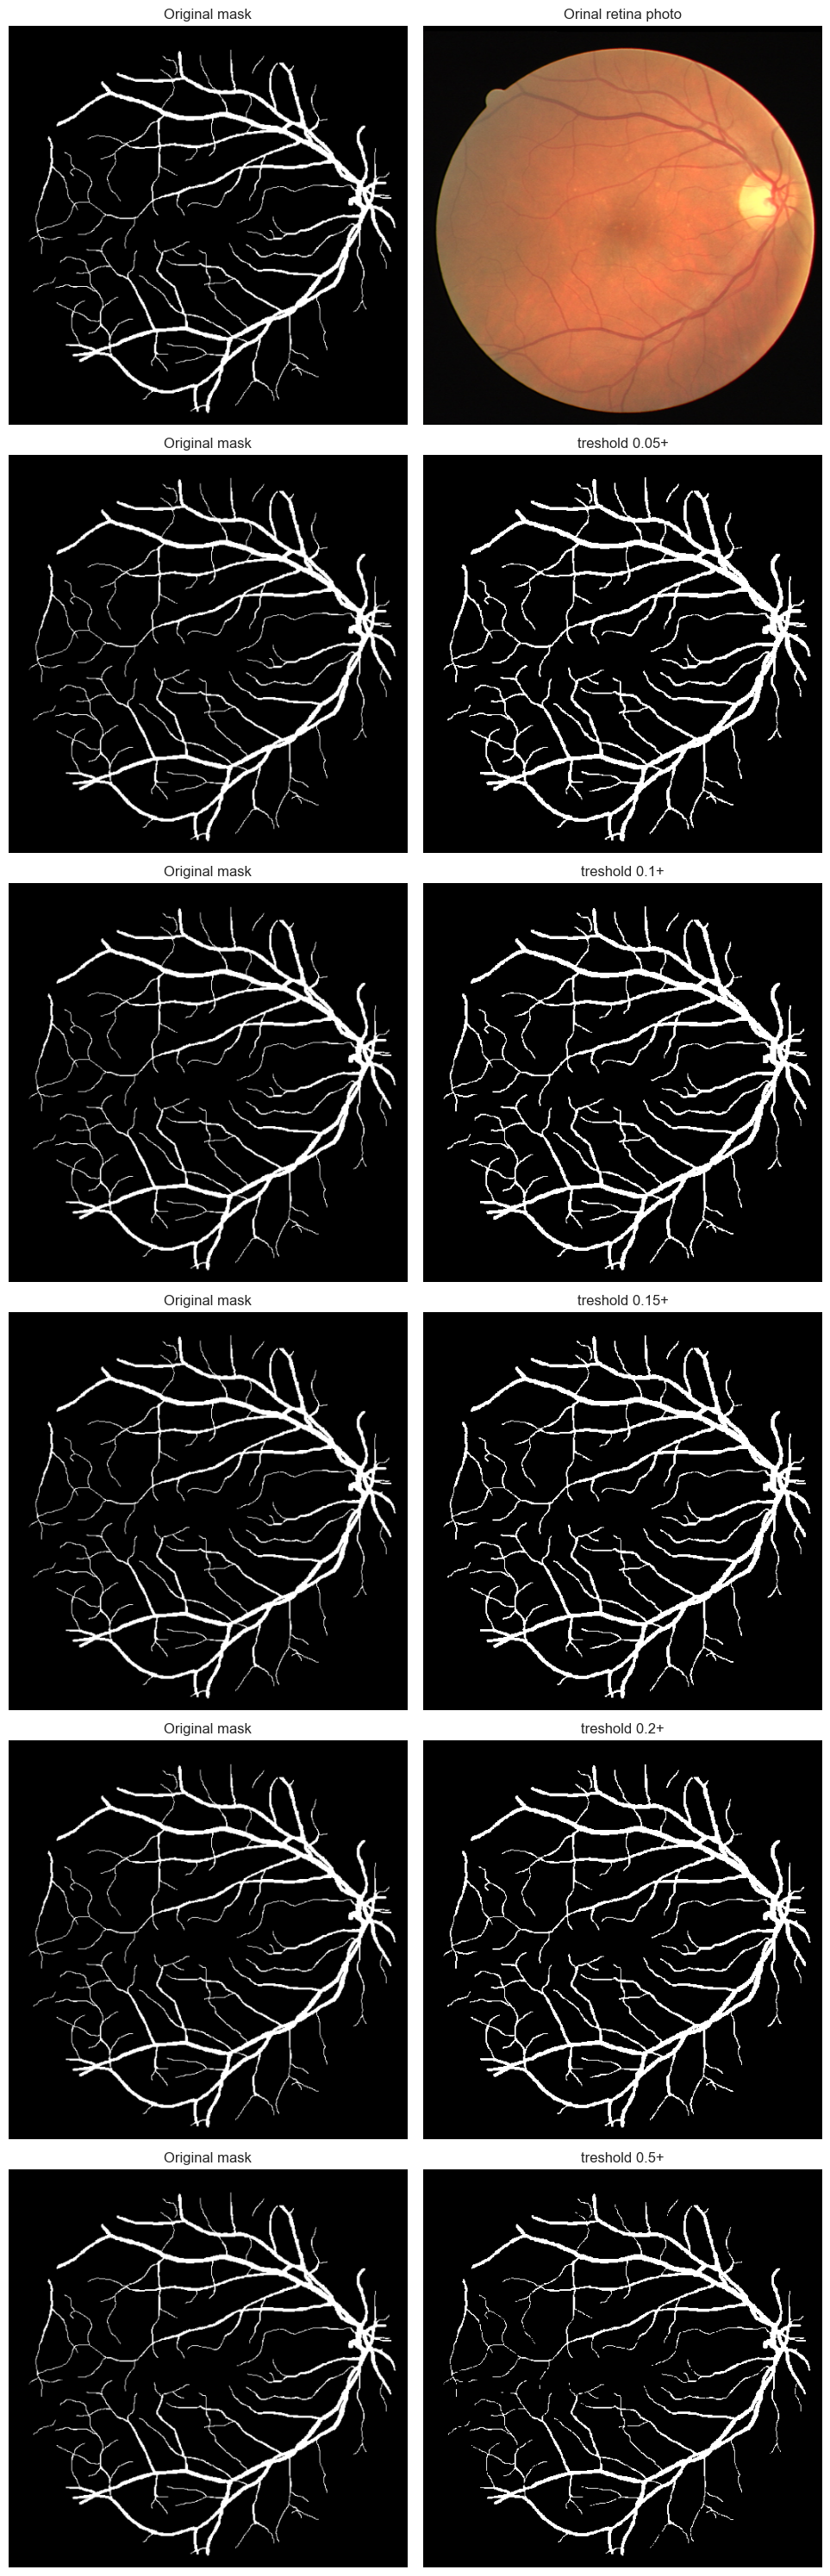

In [7]:
idx = 1  # number of sample in dataset to test some tresholds
image = train_dataset[idx][0].permute(1, 2, 0)
mask = train_dataset[idx][1].squeeze()

fig, ax = plt.subplots(6, 2, figsize=(10, 30))
plt.gray()

for i in range(6):
    ax[i, 0].imshow(mask)
    ax[i, 0].set_title("Original mask")

ax[0, 1].imshow(image)
ax[0, 1].set_title("Orinal retina photo")
ax[1, 1].imshow(mask > 0.05)
ax[1, 1].set_title("treshold 0.05+")
ax[2, 1].imshow(mask > 0.1)
ax[2, 1].set_title("treshold 0.1+")
ax[3, 1].imshow(mask > 0.15)
ax[3, 1].set_title("treshold 0.15+")
ax[4, 1].imshow(mask > 0.2)
ax[4, 1].set_title("treshold 0.2+")
ax[5, 1].imshow(mask > 0.5)
ax[5, 1].set_title("treshold 0.5+")

[a.set_axis_off() for a in ax.ravel()]
plt.tight_layout()
plt.show()



So probably the best treshold will be 0.15.

# Making final datasets and dataloaders

After choosing treshold, it's time to make right train and test datasets.

In [8]:
# Making dataset with binary mask
train_dataset = ImageDataSet(
    directory_path=os.path.join(path, "Train"),
    n_samples=80,
    sample_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(unet_size)
    ]),
    target_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(unet_size),
        NormalizeToIndex(treshold=0.15)
    ]))

test_dataset = ImageDataSet(
    directory_path=os.path.join(path, "Test"),
    n_samples=20,
    sample_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(unet_size)
    ]),
    target_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(unet_size),
        NormalizeToIndex(treshold=0.15)
    ]))

In [9]:
# making dataoaders from datasets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initializing unet model

In this project to avoid long time training I decided to use pre-trained model.

Unet is famous model to making medical segmenation do I use it.

In [10]:
unet = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    # activation="sigmoid"
)
sigmoid = nn.Sigmoid()  # to better training (loss function prefer logits instead of probability) i decided to not use sigmoid in model

# Training

I make useful function to train model.

In [11]:
def train(model=unet, output_activation=sigmoid, train_loader=train_loader, val_loader=test_loader, lr=1e-3, EPOCHS=10):
    """

    :param model: model to train, default is unet
    :param output_activation: activation function to use on logits from model, it could be identity function
    :param train_loader: dataloader with train data
    :param val_loader: dataloader with test data
    :param lr: learning rate to use in optimizer
    :param EPOCHS: number of epochs to train
    :return: tuple of 4 lists, every list consist scores per epoch. Scores are: training IoU (JaccardIndex), testing IoU, training F1 (DiceScore), testing F1
    """
    model.to(device)
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr)

    # I tested two similar losses and sum of them, but the best results gave DiceLoss
    # criterion = smp.losses.JaccardLoss(mode="binary", from_logits=True)  #this is IoU_loss
    criterion = smp.losses.DiceLoss(mode="binary", from_logits=True)  #this is F1_loss

    iou_metric = MeanIoU(num_classes=2, input_format="index", include_background=False).to(device)
    dice_metric = DiceScore(num_classes=2, input_format="index", include_background=False).to(device)
    train_iou_scores = []
    eval_iou_scores = []
    train_dice_scores = []
    eval_dice_scores = []
    print("Start training:")
    for i in tqdm(range(EPOCHS)):
        model.train()
        for X, Y in train_loader:
            X = X.to(device)
            Y = Y.to(device)
            optimizer.zero_grad()

            Y_pred = model(X)
            loss = (criterion(Y_pred, Y))
            loss.backward()
            optimizer.step()

            Y_pred = (output_activation(Y_pred) > 0.5).to(int)
            iou_metric.update(Y_pred, Y)
            dice_metric.update(Y_pred, Y)
        train_iou_scores.append(iou_metric.compute().item())
        train_dice_scores.append(dice_metric.compute().item())
        iou_metric.reset()
        dice_metric.reset()

        model.eval()
        with torch.no_grad():
            for X, Y in val_loader:
                X = X.to(device)
                Y = Y.to(device)
                Y_pred = (output_activation(model(X)) > 0.5).to(int)

                iou_metric.update(Y_pred, Y)
                dice_metric.update(Y_pred, Y)

            eval_iou_scores.append(iou_metric.compute().item())
            eval_dice_scores.append(dice_metric.compute().item())
            iou_metric.reset()
            dice_metric.reset()

        # I dont print loss, because score = 1 - loss, do it is the SAME
        print(
            f"Epoch: {str(i + 1).zfill(2)} | Train_IoU_score: {train_iou_scores[-1]:.4f}, Test_IoU_score: {eval_iou_scores[-1]:.4f} | Train_f1_score: {train_dice_scores[-1]:.4f}, Test_f1_score: {eval_dice_scores[-1]:.4f}")
    model.to("cpu")
    return train_iou_scores, train_dice_scores, eval_iou_scores, eval_dice_scores


train_iou_scores, train_f1_scores, eval_iou_scores, eval_f1_scores = train(EPOCHS=30)

Start training:


  3%|▎         | 1/30 [00:10<05:15, 10.87s/it]

Epoch: 01 | Train_IoU_score: 0.1977, Test_IoU_score: 0.1251 | Train_f1_score: 0.3246, Test_f1_score: 0.2288


  7%|▋         | 2/30 [00:19<04:26,  9.53s/it]

Epoch: 02 | Train_IoU_score: 0.3803, Test_IoU_score: 0.1395 | Train_f1_score: 0.5492, Test_f1_score: 0.2512


 10%|█         | 3/30 [00:29<04:27,  9.89s/it]

Epoch: 03 | Train_IoU_score: 0.4637, Test_IoU_score: 0.2388 | Train_f1_score: 0.6319, Test_f1_score: 0.3983


 13%|█▎        | 4/30 [00:38<04:09,  9.60s/it]

Epoch: 04 | Train_IoU_score: 0.5355, Test_IoU_score: 0.3789 | Train_f1_score: 0.6965, Test_f1_score: 0.5538


 17%|█▋        | 5/30 [00:47<03:52,  9.29s/it]

Epoch: 05 | Train_IoU_score: 0.5807, Test_IoU_score: 0.4940 | Train_f1_score: 0.7341, Test_f1_score: 0.6661


 20%|██        | 6/30 [00:56<03:39,  9.15s/it]

Epoch: 06 | Train_IoU_score: 0.6129, Test_IoU_score: 0.5514 | Train_f1_score: 0.7596, Test_f1_score: 0.7124


 23%|██▎       | 7/30 [01:06<03:33,  9.28s/it]

Epoch: 07 | Train_IoU_score: 0.6333, Test_IoU_score: 0.6030 | Train_f1_score: 0.7750, Test_f1_score: 0.7542


 27%|██▋       | 8/30 [01:15<03:25,  9.34s/it]

Epoch: 08 | Train_IoU_score: 0.6523, Test_IoU_score: 0.6308 | Train_f1_score: 0.7892, Test_f1_score: 0.7753


 30%|███       | 9/30 [01:24<03:13,  9.22s/it]

Epoch: 09 | Train_IoU_score: 0.6618, Test_IoU_score: 0.5882 | Train_f1_score: 0.7962, Test_f1_score: 0.7479


 33%|███▎      | 10/30 [01:33<03:01,  9.09s/it]

Epoch: 10 | Train_IoU_score: 0.6742, Test_IoU_score: 0.5968 | Train_f1_score: 0.8051, Test_f1_score: 0.7588


 37%|███▋      | 11/30 [01:42<02:51,  9.00s/it]

Epoch: 11 | Train_IoU_score: 0.6791, Test_IoU_score: 0.6662 | Train_f1_score: 0.8086, Test_f1_score: 0.7947


 40%|████      | 12/30 [01:50<02:40,  8.91s/it]

Epoch: 12 | Train_IoU_score: 0.6866, Test_IoU_score: 0.6455 | Train_f1_score: 0.8139, Test_f1_score: 0.7884


 43%|████▎     | 13/30 [01:59<02:30,  8.86s/it]

Epoch: 13 | Train_IoU_score: 0.6904, Test_IoU_score: 0.6827 | Train_f1_score: 0.8165, Test_f1_score: 0.8055


 47%|████▋     | 14/30 [02:08<02:20,  8.80s/it]

Epoch: 14 | Train_IoU_score: 0.6975, Test_IoU_score: 0.6821 | Train_f1_score: 0.8216, Test_f1_score: 0.8035


 50%|█████     | 15/30 [02:16<02:11,  8.75s/it]

Epoch: 15 | Train_IoU_score: 0.7040, Test_IoU_score: 0.6843 | Train_f1_score: 0.8260, Test_f1_score: 0.8097


 53%|█████▎    | 16/30 [02:25<02:02,  8.75s/it]

Epoch: 16 | Train_IoU_score: 0.7078, Test_IoU_score: 0.6852 | Train_f1_score: 0.8287, Test_f1_score: 0.8094


 57%|█████▋    | 17/30 [02:34<01:53,  8.73s/it]

Epoch: 17 | Train_IoU_score: 0.7122, Test_IoU_score: 0.6852 | Train_f1_score: 0.8316, Test_f1_score: 0.8088


 60%|██████    | 18/30 [02:43<01:45,  8.76s/it]

Epoch: 18 | Train_IoU_score: 0.7170, Test_IoU_score: 0.6938 | Train_f1_score: 0.8349, Test_f1_score: 0.8147


 63%|██████▎   | 19/30 [02:51<01:36,  8.74s/it]

Epoch: 19 | Train_IoU_score: 0.7206, Test_IoU_score: 0.6793 | Train_f1_score: 0.8374, Test_f1_score: 0.8049


 67%|██████▋   | 20/30 [03:01<01:29,  8.98s/it]

Epoch: 20 | Train_IoU_score: 0.7204, Test_IoU_score: 0.6904 | Train_f1_score: 0.8372, Test_f1_score: 0.8098


 70%|███████   | 21/30 [03:10<01:22,  9.16s/it]

Epoch: 21 | Train_IoU_score: 0.7197, Test_IoU_score: 0.6776 | Train_f1_score: 0.8367, Test_f1_score: 0.8033


 73%|███████▎  | 22/30 [03:19<01:11,  8.96s/it]

Epoch: 22 | Train_IoU_score: 0.7223, Test_IoU_score: 0.6772 | Train_f1_score: 0.8385, Test_f1_score: 0.8017


 77%|███████▋  | 23/30 [03:28<01:01,  8.85s/it]

Epoch: 23 | Train_IoU_score: 0.7275, Test_IoU_score: 0.6840 | Train_f1_score: 0.8420, Test_f1_score: 0.8055


 80%|████████  | 24/30 [03:36<00:52,  8.77s/it]

Epoch: 24 | Train_IoU_score: 0.7338, Test_IoU_score: 0.6909 | Train_f1_score: 0.8463, Test_f1_score: 0.8126


 83%|████████▎ | 25/30 [03:45<00:43,  8.77s/it]

Epoch: 25 | Train_IoU_score: 0.7358, Test_IoU_score: 0.6914 | Train_f1_score: 0.8476, Test_f1_score: 0.8138


 87%|████████▋ | 26/30 [03:53<00:34,  8.67s/it]

Epoch: 26 | Train_IoU_score: 0.7392, Test_IoU_score: 0.6832 | Train_f1_score: 0.8498, Test_f1_score: 0.8077


 90%|█████████ | 27/30 [04:02<00:25,  8.60s/it]

Epoch: 27 | Train_IoU_score: 0.7376, Test_IoU_score: 0.6933 | Train_f1_score: 0.8487, Test_f1_score: 0.8121


 93%|█████████▎| 28/30 [04:10<00:17,  8.53s/it]

Epoch: 28 | Train_IoU_score: 0.7401, Test_IoU_score: 0.6905 | Train_f1_score: 0.8504, Test_f1_score: 0.8127


 97%|█████████▋| 29/30 [04:18<00:08,  8.47s/it]

Epoch: 29 | Train_IoU_score: 0.7466, Test_IoU_score: 0.6886 | Train_f1_score: 0.8547, Test_f1_score: 0.8068


100%|██████████| 30/30 [04:27<00:00,  8.91s/it]

Epoch: 30 | Train_IoU_score: 0.7522, Test_IoU_score: 0.6956 | Train_f1_score: 0.8584, Test_f1_score: 0.8151


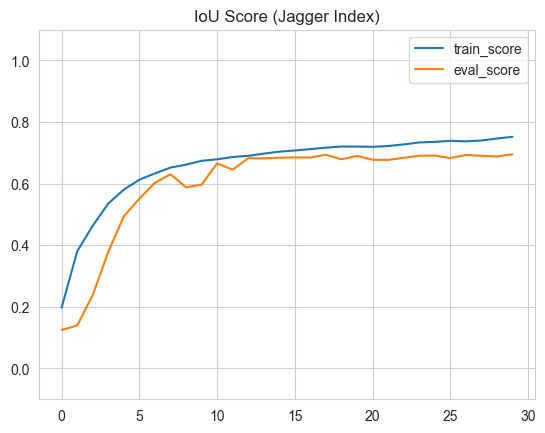

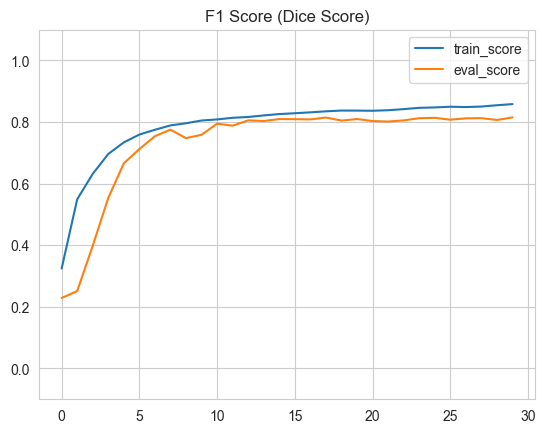

In [12]:
def plot_train_eval_scores(train_scores: list[float], eval_scores: list[float], title: str | None = None,
                           margin: float = 0.1):
    """
    :param train_scores: list of train set scores per epoch,
    :param eval_scores: list of eval scores per epoch,
    :param title: title of plot, if None then without title,
    :param margin: margin of plots,
    :return: None
    """
    plt.plot(train_scores, label="train_score")
    plt.plot(eval_scores, label="eval_score")
    if title:
        plt.title(title)
    plt.ylim(0 - margin, 1 + margin)
    plt.legend()
    plt.show()


plot_train_eval_scores(train_iou_scores, eval_iou_scores, title="IoU Score (Jagger Index)")
plot_train_eval_scores(train_f1_scores, eval_f1_scores, title="F1 Score (Dice Score)")

In [13]:
print(f"Train IoU score: {train_iou_scores[-1]}")
print(f"Test  IoU score: {eval_iou_scores[-1]}")
print(f"Train F1  score: {train_f1_scores[-1]}")
print(f"Test  F1  score: {eval_f1_scores[-1]}")

Train IoU score: 0.7521926164627075
Test  IoU score: 0.695576548576355
Train F1  score: 0.858354389667511
Test  F1  score: 0.8150674700737


# Checking results on example sample

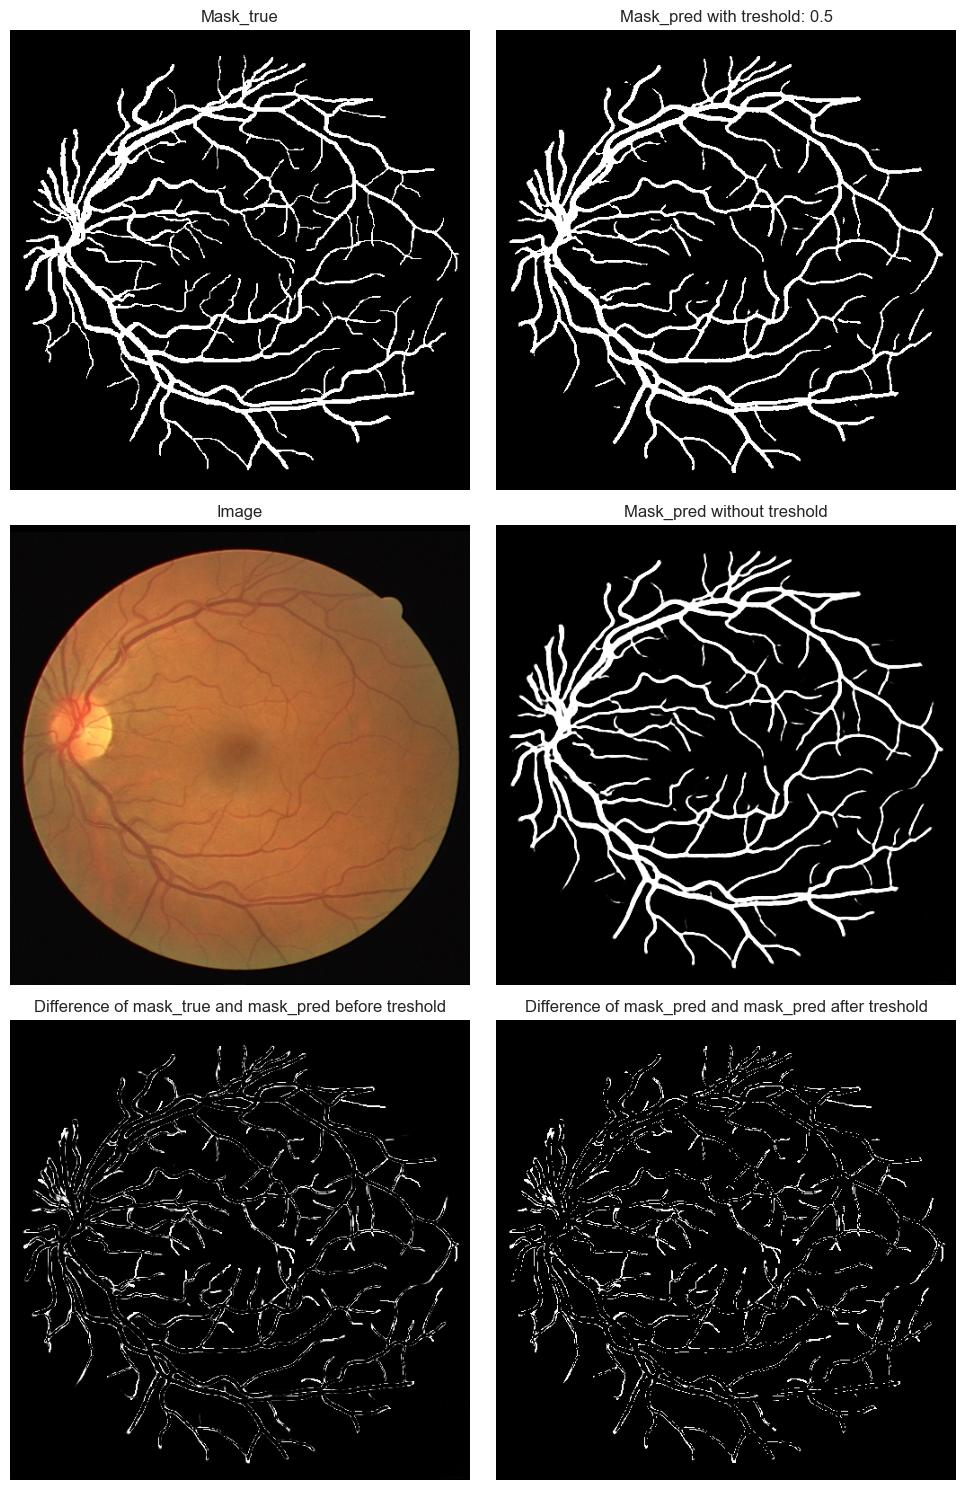

In [16]:
idx = 0  # number of sample
treshold = 0.5 # treshold to change pobability output from model to index of class: 1 if blood vessels, 0 if background
unet.to("cpu")

with torch.no_grad():
    unet.eval()

    image = test_dataset[idx][0]
    mask_true = test_dataset[idx][1].squeeze()
    mask_pred = sigmoid(unet(image.unsqueeze(0)))
    mask_pred_after_treshold = (mask_pred.squeeze() > treshold).int()
    image = image.permute(1, 2, 0)
    mask_pred = mask_pred.squeeze()

    fig, ax = plt.subplots(3, 2, figsize=(10, 15))

    ax[0, 0].imshow(mask_true)
    ax[0, 0].set_title("Mask_true")
    ax[0, 1].imshow(mask_pred_after_treshold)
    ax[0, 1].set_title(f"Mask_pred with treshold: {treshold}")
    ax[1, 0].imshow(image)
    ax[1, 0].set_title("Image")
    ax[1, 1].imshow(mask_pred)
    ax[1, 1].set_title("Mask_pred without treshold")
    ax[2, 0].imshow((mask_true - mask_pred).abs())
    ax[2, 0].set_title("Difference of mask_true and mask_pred before treshold")
    ax[2, 1].imshow((mask_true - mask_pred_after_treshold).abs())
    ax[2, 1].set_title("Difference of mask_pred and mask_pred after treshold")

    for a in ax.ravel():
        a.set_axis_off()
    plt.tight_layout()
    plt.show()
